In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/content/mnist_train.csv')
data = np.array(data)

In [ ]:
data = np.array(data)
m, _ = data.shape
np.random.shuffle(data) # shuffle data

X_test = data[:1000, 1:] / 255. # split data b/w train and test, and rescale
Y_test = data[:1000, 0]

X_train = data[1000:m, 1:] / 255.
Y_train = data[1000:m, 0]

6


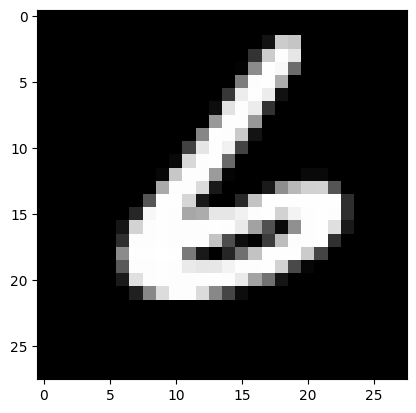

In [ ]:
img = np.reshape(X_train[1], (28,28)) # visualize a data point and its label
plt.imshow(img, cmap = 'gray')
print(Y_train[1])

In [ ]:
Y_train

array([4, 6, 7, ..., 1, 8, 7])

In [ ]:
def relu(Z):
  """
  inputs:
    Z (ndarray (m, n)): 2D array of raw output from weights and biases

  outputs:
    A (ndarray (m, n)): 2D array of only positive values in Z
  """

  A = np.maximum(Z, 0)

  return A

In [ ]:
def relu_deriv(Z):
  """
  inputs:
    Z (ndarray (m, n)): 2D array of raw output from weights and biases

  outputs:
    z_deriv (ndarray (m, n)): 2D array w/value 1 where Z >= 0 and value 0 where z < 0
  """

  Z_deriv = (Z >= 0)

  return Z_deriv

In [ ]:
def softmax(Z):
  """
  inputs:
    Z (ndarray (m, n)): 2D array of raw output from weights and biases

  outputs:
    A (ndarray (m, n)): 2D array where each value is e^z / sum(e^z of the row)

  notes:
    transposed twice because of trouble with numpy broadcasting
  """

  Z = Z.T
  A = np.exp(Z) / sum(np.exp(Z))
  A = A.T

  return A

In [ ]:
def one_hot(Y):
  """
  inputs:
    Y (ndarray (m, 1)): column matrix of true labels

  outputs:
    one_hot_y (ndarray (m, 10)): 2D matrix where each row is an example, the column with a 1 is the label, and the rest are 0's
  """

  one_hot_Y = np.zeros((Y.size, np.max(Y) + 1)) # zero matrix with rows same as Y, (9+1) = 10 columns
  one_hot_Y[np.arange(Y.size), Y] = 1 # for each row, set a 1 at the index with the label

  return one_hot_Y

In [ ]:
def init_network():
  """
  inputs:

  outputs:
    W_list (list (1, num_layers)): List of weight matrices, each index is a 2D matrix containing all weights in a layer
    b_list (list (1, num_layers-1)): List of bias matrices, each index is a row matrix containing all biases in a layer
  """

  W1 = np.random.rand(784, 16) - 0.5 # create random weight matrices corresponding to layers [784, 16, 16, 10]
  W2 = np.random.rand(16,16) - 0.5
  W3 = np.random.rand(16,10) - 0.5
  W_list = [W1, W2, W3] # add weight matrices to list

  b1 = np.random.rand(1, 16) - 0.5 # create random bias matrices corresponding to layers [784, 16, 16, 10]
  b2 = np.random.rand(1, 16) - 0.5
  b3 = np.random.rand(1, 10) - 0.5
  b_list = [b1, b2, b3] # add bias matrices to list

  return W_list, b_list

In [ ]:
def forward_prop(X, W_list, b_list):
  """
  inputs:
    X (ndarray (m, 784)): each row is a training example, each column is a brightness intensity that makes up the image
    W_list (list (1, num_layers)): List of weight matrices, each index is a 2D matrix containing all weights in a layer
    b_list (list (1, num_layers-1)): List of bias matrices, each index is a row matrix containing all biases in a layer

  outputs:
    Z_list ((list (1, num_layers))): list of result matrices before activation, each is a 2D matrix w/m rows and num_units cols
    A_list ((list (1, num_layers))): list of result matrices after activation, each is a 2D matrix w/m rows and num_units cols
  """

  Z1 = X.dot(W_list[0]) + b_list[0] # apply forward prop formula to compute layer values before activation
  A1 = relu(Z1) # apply relu activation to first 2 layers

  Z2 = A1.dot(W_list[1]) + b_list[1]
  A2 = relu(Z2)

  Z3 = A2.dot(W_list[2]) + b_list[2]
  A3 = softmax(Z3) # apply softmax activation to last layer

  A_list = [X, A1, A2, A3] # update network lists, including input values in A_list
  Z_list = [Z1, Z2, Z3]

  return A_list, Z_list

In [ ]:
def back_prop(Y, A_list, Z_list, W_list, b_list):
  """
  inputs:
    Y (ndarray (m, 1)): column matrix of true labels
    Z_list ((list (1, num_layers))): list of result matrices before activation, each is a 2D matrix w/m rows and num_units cols
    A_list ((list (1, num_layers))): list of result matrices after activation, each is a 2D matrix w/m rows and num_units cols
    W_list (list (1, num_layers)): List of weight matrices, each index is a 2D matrix containing all weights in a layer
    b_list (list (1, num_layers-1)): List of bias matrices, each index is a row matrix containing all biases in a layer

  outputs:
    dW_list (list (1, num_layers)): list of weight adjustment matrices, each index is a 2D matrix with weight adjustments for each weight
    db_list (list (1, num_layers-1)): list of bias adjustment matrices, each index is a row matrix with bias adjustments for each bias
  """

  one_hot_Y = one_hot(Y) # encoding is done here in case you choose to shuffle the data/use batch Grad Desc for each iteration

  dZ3 = A_list[-1] - one_hot_Y # final layer dW and db have unique formula b/c softmax activation instead of relu
  dW3 = (1 / m) * ((A_list[-2].T).dot(dZ3))
  db3 = (1 / m) * np.sum(dZ3, axis = 0)

  dZ2 = dZ3.dot(W_list[-1].T) * relu_deriv(Z_list[-2]) # apply back prop formula with indexing
  dW2 = (1 / m) * (A_list[-3].T).dot(dZ2)
  db2 = (1 / m) * np.sum(dZ2, axis = 0)

  dZ1 = dZ2.dot(W_list[-2].T) * relu_deriv(Z_list[-3])
  dW1 = (1 / m) * (A_list[-4].T).dot(dZ1)
  db1 = (1 / m) * np.sum(dZ1, axis = 0)

  dW_list = [dW1, dW2, dW3] # add adjustment matrices to the list from the front to keep with the format of W_list
  db_list = [db1, db2, db3]

  return dW_list, db_list

In [ ]:
def update_params(W_list, b_list, dW_list, db_list, alpha):
  """
  inputs:
    W_list (list (1, num_layers)): List of weight matrices, each index is a 2D matrix containing all weights in a layer
    b_list (list (1, num_layers-1)): List of bias matrices, each index is a row matrix containing all biases in a layer
    dW_list (list (1, num_layers)): list of weight adjustment matrices, each index is a 2D matrix with weight adjustments for each weight
    db_list (list (1, num_layers-1)): list of bias adjustment matrices, each index is a row matrix with bias adjustments for each bias
    alpha (float): learning rate

  outputs:
    W_list (list (1, num_layers)): List of weight matrices, each index is a 2D matrix containing all weights in a layer
    b_list (list (1, num_layers-1)): List of bias matrices, each index is a row matrix containing all biases in a layer
  """

  W_list = [w - alpha*dw for w, dw in zip(W_list, dW_list)] # use list comprehension to update the W and b matrices
  b_list = [b - alpha*db for b, db in zip(b_list, db_list)]

  return W_list, b_list

In [ ]:
def get_predictions(A3):
  """
  inputs:
    A3 (ndarray (m, 10)): last layer values after softmax

  outputs:
    predictions (ndarray (m, 1)): column matrix with predictions of label for each X
  """

  predictions = np.argmax(A3, axis = 1) # softmax returns probability of being a value, so highest probability is the label give by NN

  return predictions

In [ ]:
def get_accuracy(predictions, Y):
  """
  inputs:
    predictions (ndarray (m, 1)): column matrix with predictions of label for each X
    Y (ndarray (m, 1)): column matrix of true labels

  outputs:
    accuracy (float): number correct predictions / number total predictions
  """

  accuracy = np.sum(predictions == Y) / Y.size

  return accuracy

In [ ]:
def gradient_descent(X, Y, units_list, alpha, iterations, resume = False, W_list = 0, b_list = 0):
  """
  inputs:
    X (ndarray (m, 784)): each row is a training example, each column is a brightness intensity that makes up the image
    Y (ndarray (m, 1)): column matrix of true labels
    units_list (list (1, num_layers)): number of units in each layer of the neural network, starting with input layer
    alpha (float): learning rate
    iterations (int): number of times to run gradient descent over all of the data
    resume (bool): allows continuing gradient descent using previously trained weights and biases
    W_list (list (1, num_layers)): same as before, but set to 0 as default to optionally allow using previously trained weights
    b_list (list (1, num_layers-1)): same as before, but set to 0 as default to optionally allow using previously trained biases

  outputs:
    W_list (list (1, num_layers)): List of weight matrices, each index is a 2D matrix containing all weights in a layer
    b_list (list (1, num_layers-1)): List of bias matrices, each index is a row matrix containing all biases in a layer
    accuracy_list (list (1, iterations)): record of accuracy score for each iteration
    iterations_list (list (1, iterations)): record of iteration number for each iterations (list for consistency, np.arange would work fine)
  """

  lists_given = isinstance(W_list, list) and isinstance(b_list, list)
  if (not resume) and (not lists_given):
    W_list, b_list = init_network(units_list) # load trained weights and baises if resume is true and W_list/b_list are given

  accuracy_list = [] # record accuracy v.s. iterations for visualizing data
  iterations_list = []

  for i in range(iterations+1):
    A_list, Z_list = forward_prop(X, W_list, b_list) # run gradient descent algorithm
    dW_list, db_list = back_prop(Y, A_list, Z_list, W_list, b_list)
    W_list, b_list = update_params(W_list, b_list, dW_list, db_list, alpha)

    predictions = get_predictions(A_list[-1]) # update accuracy and iterations lists
    accuracy = get_accuracy(predictions, Y)
    accuracy_list.append(accuracy)
    iterations_list.append(i)

    if i % 50 == 0: # visualize training while progress is continuing
      print("Iteration: ", i)
      print(predictions, Y)
      print(accuracy)

  return W_list, b_list, accuracy_list, iterations_list

In [ ]:
start = time.time()
W_list, b_list, accuracy_list, iterations_list = gradient_descent(X_train, Y_train, 0.25, 1000)
print('total time taken to train: ', (time.time() - start))

Iteration:  0
[3 0 1 ... 0 1 0] [4 6 7 ... 1 8 7]
0.06818759639993899
Iteration:  50
[7 6 9 ... 1 9 7] [4 6 7 ... 1 8 7]
0.6460278987779454
Iteration:  100
[9 6 7 ... 1 9 7] [4 6 7 ... 1 8 7]
0.7409447617756233
Iteration:  150
[9 6 7 ... 1 9 7] [4 6 7 ... 1 8 7]
0.8166748588959135
Iteration:  200
[9 6 7 ... 1 9 7] [4 6 7 ... 1 8 7]
0.8430142883777691
Iteration:  250
[9 6 7 ... 1 9 7] [4 6 7 ... 1 8 7]
0.8617773182596316
Iteration:  300
[9 6 7 ... 1 8 7] [4 6 7 ... 1 8 7]
0.8730656451804268
Iteration:  350
[9 6 7 ... 1 8 7] [4 6 7 ... 1 8 7]
0.8822352921235953
Iteration:  400
[9 6 7 ... 1 8 7] [4 6 7 ... 1 8 7]
0.8888625230936118
Iteration:  450
[9 6 7 ... 1 8 7] [4 6 7 ... 1 8 7]
0.8954897540636282
Iteration:  500
[9 6 7 ... 1 8 7] [4 6 7 ... 1 8 7]
0.900049153375481
Iteration:  550
[9 6 7 ... 1 8 7] [4 6 7 ... 1 8 7]
0.9008118781674266
Iteration:  600
[9 6 7 ... 1 8 7] [4 6 7 ... 1 8 7]
0.9076255529754742
Iteration:  650
[9 6 7 ... 1 8 7] [4 6 7 ... 1 8 7]
0.9100323734300582
Iteration

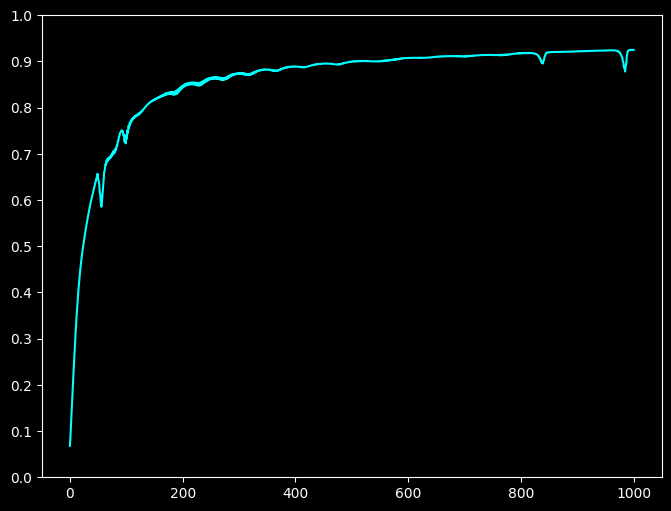

In [ ]:
plt.style.use('dark_background')  # Predefined style for black background
fig, ax = plt.subplots(1, 1, figsize = (8,6)) # define plot and set figure size
ax.plot(iterations_list, accuracy_list, color='cyan')
ax.set_ylim(0., 1.) # Set plot dimension
ax.set_xlim(0, 1000)
ax.set_yticks(np.arange(0, 1.1, 0.1))  # Set y-axis ticks at every 0.1 interval to 1.0
ax.set_xticks(np.arange(0, 1001, 100)) # Set x-axis ticks at every 100 interval to 1000
ax.set_ylabel('Accuracy', fontsize = 15)
ax.set_xlabel('Iteration', fontsize = 15)
ax.set_title('MNIST Neural Network Training Progress')
plt.show()

In [ ]:
A_list, Z_list = forward_prop(X_test, W_list, b_list) # apply trained weights and biases on test data
predictions = get_predictions(A_list[-1])
accuracy = get_accuracy(predictions, Y_test)
print(predictions[:5], Y_test[:5])
print(accuracy)

[9 8 8 3 6] [9 8 8 3 6]
0.923


prediction:  9 actual:  9


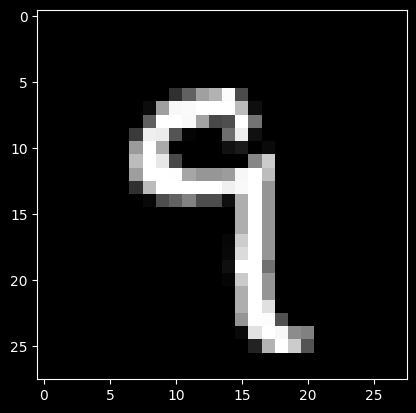

In [ ]:
img = np.reshape(X_test[0], (28,28)) # visualize results
plt.imshow(img, cmap = 'gray')
print('prediction: ', predictions[0], 'actual: ', Y_test[0])